In [ ]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble	import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble	import StackingClassifier

from sklearn.metrics import (
  accuracy_score, precision_score, recall_score, f1_score,
  matthews_corrcoef, roc_auc_score, confusion_matrix
)

import xgboost as xgb

In [2]:
df = pd.read_csv("data/heart_raw.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.isnull().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,920.000000,920.000000,920.000000,861.000000,890.000000,830.000000,918.000000,865.000000,865.000000,858.000000,611.000000,309.000000,434.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.166265,0.604575,137.545665,0.389595,0.878788,1.770867,0.676375,5.087558,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.372543,0.805827,25.926276,0.487941,1.091226,0.619256,0.935653,1.919075,1.142693
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,175.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,268.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [5]:
df_clean = df.dropna()
len(df_clean)

299

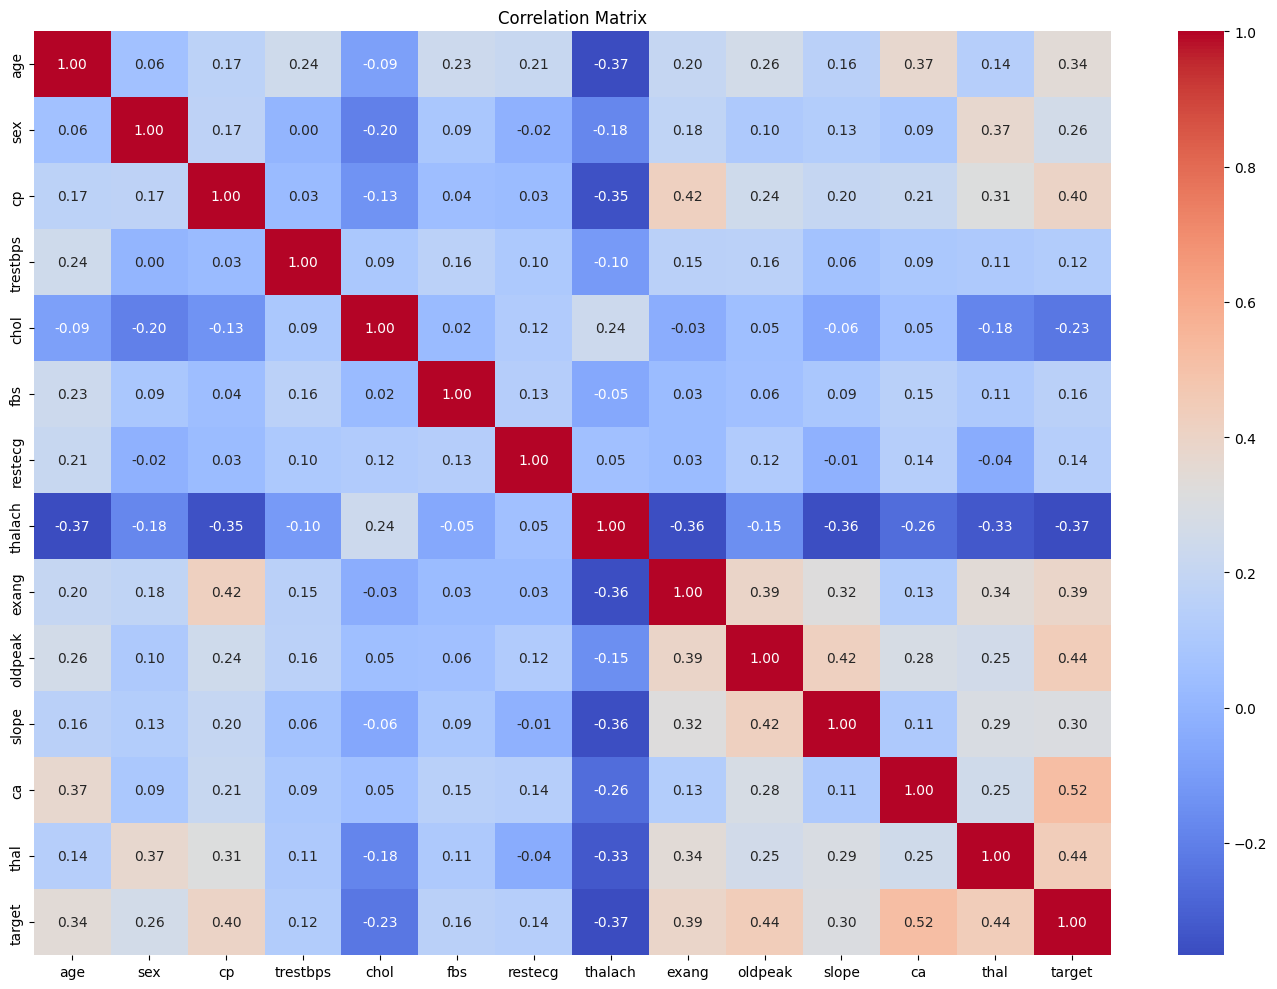

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
correlation_matrix = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [7]:
num_cols = [
	'age', 'trestbps', 'chol', 'thalach', 'oldpeak'
]
cat_cols = [
	'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'
]

In [8]:
df_binary = df.copy()
df_binary["target"] = (df_binary["target"] > 0).astype(int)

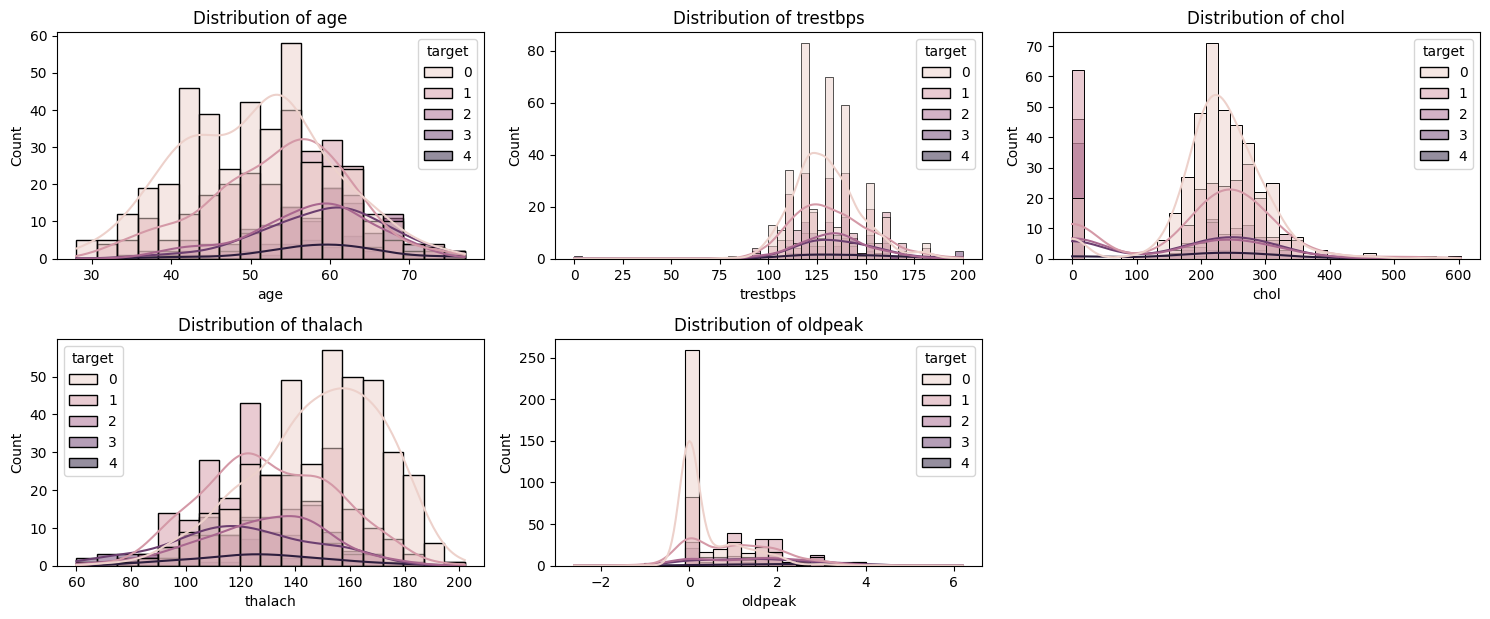

In [9]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(num_cols):
	plt.subplot(4, 3, i+1)
	sns.histplot(data=df, x=feature, hue='target', kde=True)
	plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

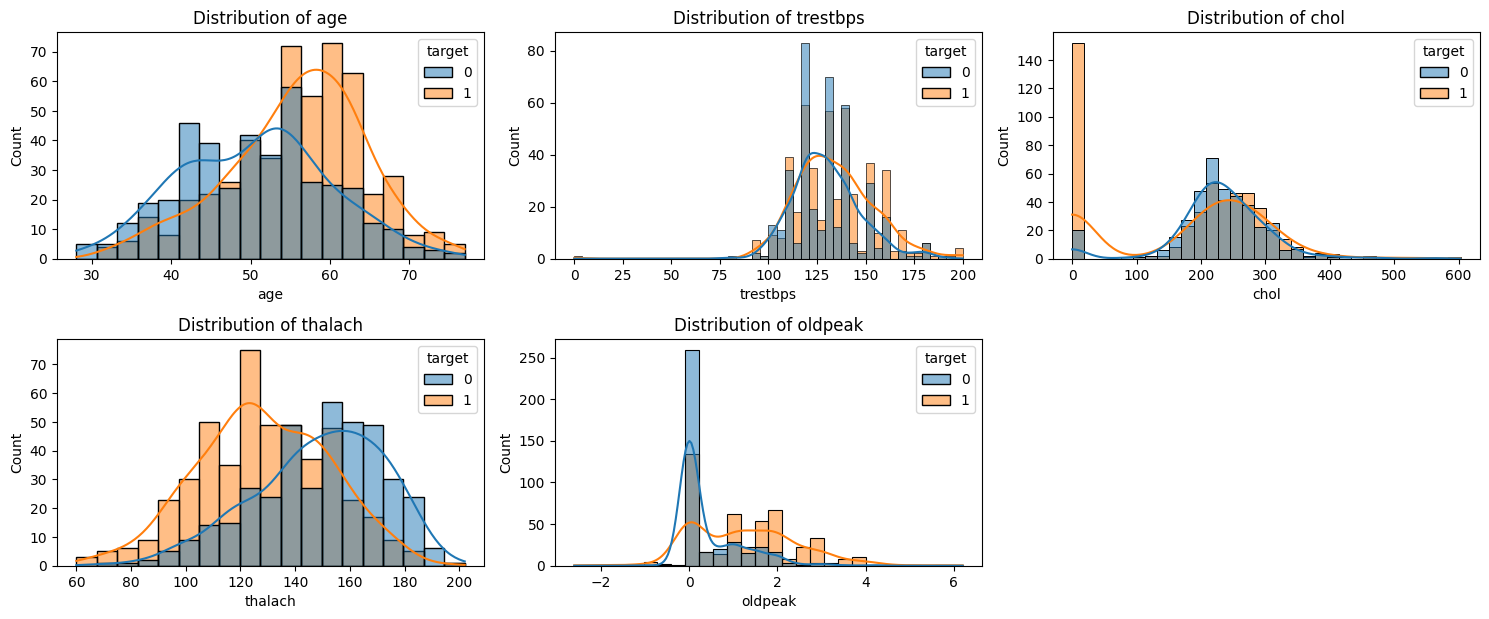

In [10]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(num_cols):
	plt.subplot(4, 3, i+1)
	sns.histplot(data=df_binary, x=feature, hue='target', kde=True)
	plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [11]:
X = df.drop('target', axis=1)
y = df['target']

RANDOM_STATE=42

In [12]:
imputer = IterativeImputer(max_iter=100, random_state=RANDOM_STATE)

X_num_imp = pd.DataFrame(
	imputer.fit_transform(X[num_cols]), columns=num_cols
)

imputer = SimpleImputer(strategy="most_frequent")

X_cat_imp = pd.DataFrame(
	imputer.fit_transform(X[cat_cols]), columns=cat_cols
)

X_num_imp.isnull().sum(), X_cat_imp.isnull().sum()

scaler = StandardScaler()
X_scaled = pd.DataFrame(
	scaler.fit_transform(X_num_imp),
	columns=num_cols,
)

encoder = OneHotEncoder(sparse_output=False)
X_encoded = pd.DataFrame(
	encoder.fit_transform(X_cat_imp),
	columns=encoder.get_feature_names_out(cat_cols),
)

X_proc = pd.concat([X_scaled, X_encoded], axis=1)

In [13]:
y = (y > 0).astype(int)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

X_train shape: (736, 28)
X_test shape: (184, 28)
y_train shape: (736,)
y_test shape: (184,)

Class distribution in training set:
target
1    0.552989
0    0.447011
Name: proportion, dtype: float64

Class distribution in test set:
target
1    0.554348
0    0.445652
Name: proportion, dtype: float64


In [ ]:
# y_train_resampled = (y_train_resampled > 0).astype(int)
# y_test = (y_test > 0).astype(int)

In [17]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [18]:
preds = rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

pd.DataFrame({
	"Metrics": ["Accuracy", "F1-Score", "Recall", "Precision", "Sensitivity", "Specificity", "MCC", "Auc"],
	"Results": [accuracy_score(y_test, preds), f1_score(y_test, preds), recall_score(y_test, preds), precision_score(y_test, preds), sensitivity, specificity, matthews_corrcoef(y_test, preds), roc_auc_score(y_test, preds)],
})

,Metrics,Results
0,Accuracy,0.864130
1,F1-Score,0.882629
2,Recall,0.921569
3,Precision,0.846847
4,Sensitivity,0.921569
5,Specificity,0.792683
6,MCC,0.725664
7,Auc,0.857126


In [20]:
X_train_resampled.shape

(736, 28)

In [23]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

In [22]:
search_space = {
  'n_estimators': Integer(50, 150),
  'max_depth': Integer(3, 15),
  'min_samples_split': Integer(2, 10),
  'min_samples_leaf': Integer(1, 5),
  'max_features': Categorical(['sqrt', 'log2']),  
  'criterion':  Categorical(['gini', 'entropy']),
  'bootstrap': Categorical([True, False])
}

In [40]:
opt = BayesSearchCV(
  estimator=RandomForestClassifier(random_state=RANDOM_STATE),
  search_spaces=search_space,
  n_iter=100,
  scoring='precision',
  cv=5,
  n_jobs=2,
  random_state=RANDOM_STATE,
	verbose=10,
)

In [41]:
%%time
opt.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START bootstrap=True, criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=85
[CV 2/5; 1/1] START bootstrap=True, criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=85
[CV 1/5; 1/1] END bootstrap=True, criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=85;, score=0.807 total time=   0.1s
[CV 3/5; 1/1] START bootstrap=True, criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=85
[CV 2/5; 1/1] END bootstrap=True, criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=85;, score=0.795 total time=   0.1s
[CV 4/5; 1/1] START bootstrap=True, criterion=entropy, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=85
[CV 3/5; 

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              n_iter=100, n_jobs=2, random_state=42, scoring='precision',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize')},
              verbose=10)

In [42]:
res = opt.optimizer_results_[0]

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

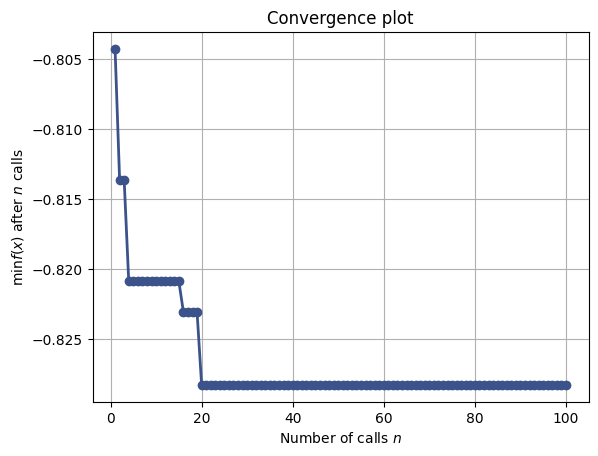

In [43]:
plot_convergence(res)

<Axes: >

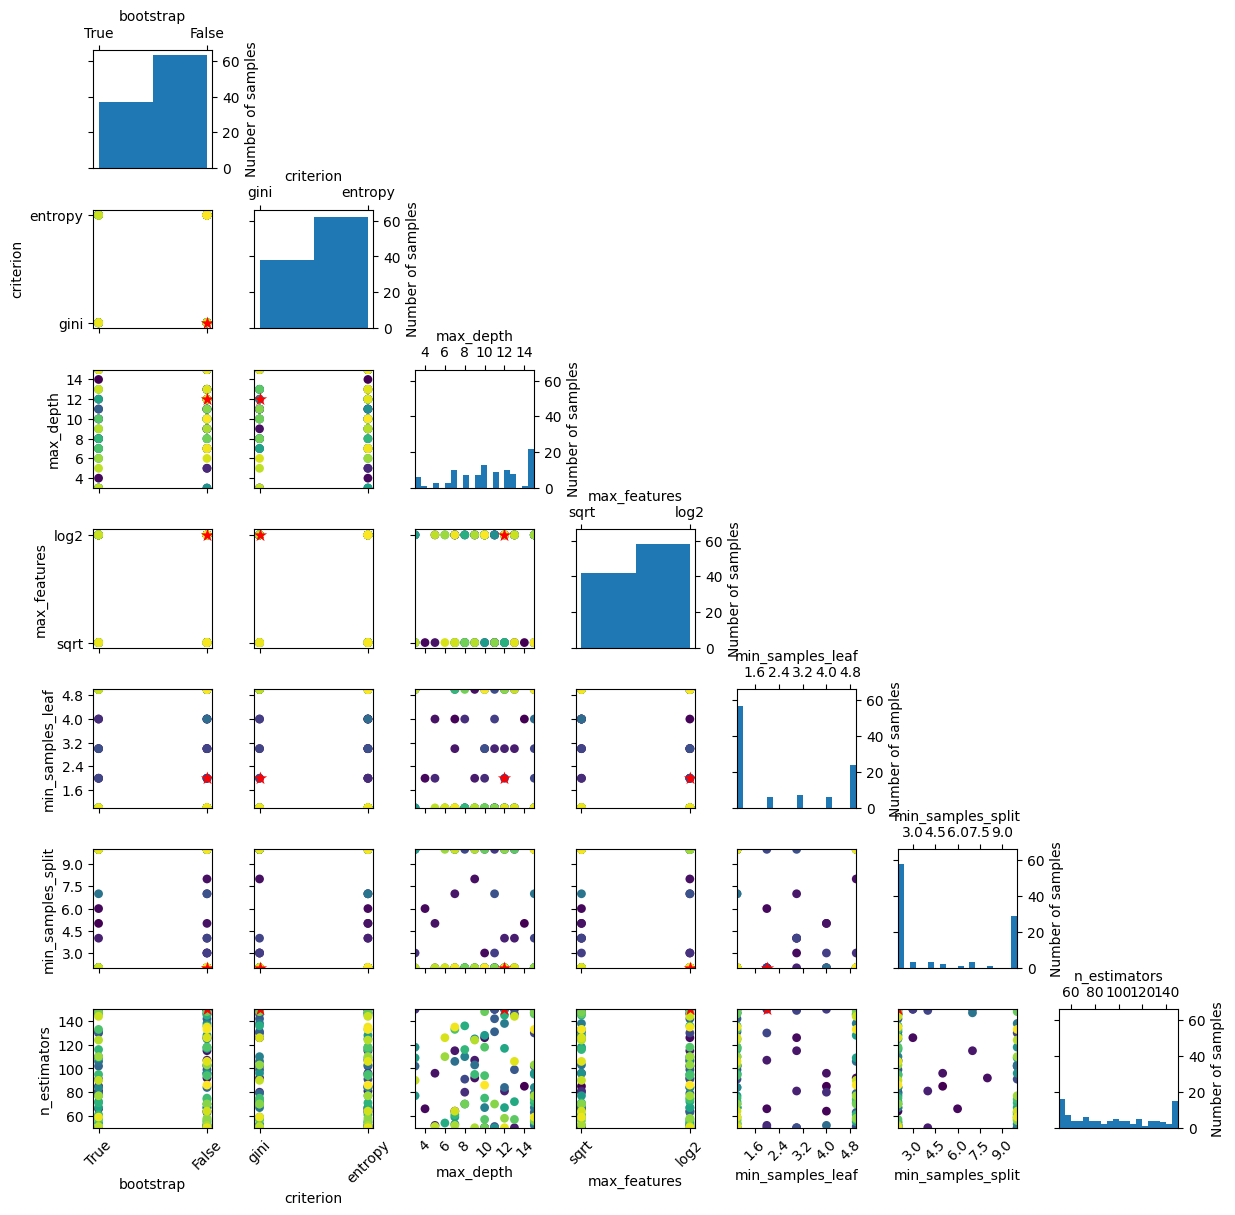

In [44]:
plot_evaluations(res)

In [45]:
preds = opt.best_estimator_.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

pd.DataFrame({
	"Metrics": ["Accuracy", "F1-Score", "Recall", "Precision", "Sensitivity", "Specificity", "MCC", "Auc"],
	"Results": [accuracy_score(y_test, preds), f1_score(y_test, preds), recall_score(y_test, preds), precision_score(y_test, preds), sensitivity, specificity, matthews_corrcoef(y_test, preds), roc_auc_score(y_test, preds)],
})

,Metrics,Results
0,Accuracy,0.869565
1,F1-Score,0.885714
2,Recall,0.911765
3,Precision,0.861111
4,Sensitivity,0.911765
5,Specificity,0.817073
6,MCC,0.735731
7,Auc,0.864419


In [44]:
from imblearn import pipeline
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
sampler = SMOTEENN(random_state=RANDOM_STATE)

pipe = pipeline.Pipeline([
	('sampler', sampler),
	('clf', clf),
])

In [45]:
scores = cross_val_score(pipe, X_train, y_train,
	cv=5,
	scoring='roc_auc',
	n_jobs=2
)
scores

array([0.89292313, 0.89737336, 0.87420501, 0.86840629, 0.87476618])

In [46]:
import optuna
import optuna.visualization as vis
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn import pipeline

def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 50, 1000)
  max_depth = trial.suggest_int('max_depth', 3, 30)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

  sampler_name = trial.suggest_categorical(
    'sampler',
    ['none', 'smote', 'undersample', 'smoteenn']
  )
  if sampler_name == 'smote':
    sampler = SMOTE(random_state=RANDOM_STATE)
  elif sampler_name == 'undersample':
    sampler = RandomUnderSampler(random_state=RANDOM_STATE)
  elif sampler_name == 'smoteenn':
    sampler = SMOTEENN(random_state=RANDOM_STATE)
  else:
    sampler = 'passthrough'

  clf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    random_state=RANDOM_STATE,
  )

  pipe = pipeline.Pipeline([
    ('sampler', sampler),
    ('clf', clf),
  ])

  scores = cross_val_score(pipe, X_train, y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=2
  )
  return scores.mean()

In [47]:
%%time
n_trials = 1000

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2025-05-28 21:38:27,026] A new study created in memory with name: no-name-dc241e7c-4711-423c-b8ce-37f422578cb8


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-05-28 21:38:29,246] Trial 0 finished with value: 0.8841029571652879 and parameters: {'n_estimators': 886, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'sampler': 'smote'}. Best is trial 0 with value: 0.8841029571652879.
[I 2025-05-28 21:38:30,644] Trial 1 finished with value: 0.8835588530710483 and parameters: {'n_estimators': 626, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'sampler': 'none'}. Best is trial 0 with value: 0.8841029571652879.
[I 2025-05-28 21:38:32,203] Trial 2 finished with value: 0.8862761658696618 and parameters: {'n_estimators': 648, 'max_depth': 23, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'sampler': 'none'}. Best is trial 2 with value: 0.8862761658696618.
[I 2025-05-28 21:38:34,136] Trial 3 finished with value: 0.8834787103892794 and parameters: {'n_estimators': 855, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_featu

In [27]:
import plotly

In [51]:
best_params = study.best_params
best_trial = study.best_trial

print(f"Best trial#{best_trial.number}: value={best_trial.value}")
print("Best params:", best_params)

Best trial#787: value=0.890160173059902
Best params: {'n_estimators': 491, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'sampler': 'smote'}


In [53]:
best_sampler = best_params['sampler']
del best_params['sampler']

In [55]:
if best_sampler == 'smote':
	sampler = SMOTE(random_state=RANDOM_STATE)
elif best_sampler == 'undersample':
	sampler = RandomUnderSampler(random_state=RANDOM_STATE)
elif best_sampler == 'smoteenn':
	sampler = SMOTEENN(random_state=RANDOM_STATE)
else:
	sampler = 'passthrough'

best_clf = RandomForestClassifier(
	**best_params
)

pipe = pipeline.Pipeline([
	('sampler', sampler),
	('clf', best_clf),
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        min_samples_split=16,
                                        n_estimators=491))])

In [ ]:
# best_model = RandomForestClassifier(
#   **best_params,
#   random_state=RANDOM_STATE,
# )
# best_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=18, max_features='log2', n_estimators=225,
                       random_state=42)

In [57]:
best_clf = pipe['clf']

In [58]:
preds = best_clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

pd.DataFrame({
	"Metrics": ["Accuracy", "F1-Score", "Recall", "Precision", "Sensitivity", "Specificity", "MCC", "Auc"],
	"Results": [accuracy_score(y_test, preds), f1_score(y_test, preds), recall_score(y_test, preds), precision_score(y_test, preds), sensitivity, specificity, matthews_corrcoef(y_test, preds), roc_auc_score(y_test, preds)],
})

,Metrics,Results
0,Accuracy,0.864130
1,F1-Score,0.882629
2,Recall,0.921569
3,Precision,0.846847
4,Sensitivity,0.921569
5,Specificity,0.792683
6,MCC,0.725664
7,Auc,0.857126


In [59]:
fig1 = vis.plot_optimization_history(study)
fig1.show()

In [49]:
fig2 = vis.plot_param_importances(study)
fig2.show()

In [60]:
fig3 = vis.plot_parallel_coordinate(study)
fig3.show()

In [34]:
fig4 = vis.plot_slice(study)
fig4.show()

In [35]:
fig5 = vis.plot_contour(study)
fig5.show()

In [20]:
from ray import tune
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

In [21]:
scheduler = HyperBandForBOHB(
  time_attr="training_iteration",
  max_t=100,
)

In [22]:
search_alg = TuneBOHB()

In [24]:
%%time
tune.run(
  RandomForestClassifier(random_state=RANDOM_STATE),
  scheduler=scheduler,
  search_alg=search_alg,
  resources_per_trial={
    "cpu": 2,
    "gpu": 1
  },
  config={
    'n_estimators': tune.randint(50, 150),
    'max_depth': tune.randint(3, 15),
    'min_samples_split': tune.randint(2, 10),
    'min_samples_leaf': tune.randint(1, 5),
    'max_features': tune.choice(['sqrt', 'log2']),  
    'criterion':  tune.choice(['gini', 'entropy']),
    'bootstrap': tune.choice([True, False])
  },
  num_samples=50,
  metric="roc_auc",
  mode="max"
)

2025-05-28 19:36:25,805	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


TuneError: Improper 'run' - not string nor trainable.